In [3]:
import sys
import numpy as np # linear algebra

from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import datetime # importing datetime
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## for Deep-learing:
import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

import itertools
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

## Pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)

C:\Users\royalgifts\AppData\Local\Temp\ipykernel_4328\1594231187.py:40: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [5]:
df = pd.read_csv("household_power_consumption.txt",
                   sep=";", parse_dates={"Date_time":["Date", "Time"]},
                   infer_datetime_format=True,
                   low_memory=False,
                   na_values=["nan","?"],
                   index_col='Date_time')

In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
df.shape

(2075259, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [9]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [10]:
# Split the data into numeric and categorical data
num_data = df.select_dtypes(include=[int, float])
cat_data = df.select_dtypes(include=["O"])

# Check the shape of the data
num_data.shape, cat_data.shape

((2075259, 7), (2075259, 0))

In [11]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [12]:
# Get the variables with NaNs
NA_THRESH = 0
num_vars_wf_na = [
    var for var in num_data.columns if num_data[var].isna().sum() > NA_THRESH
]

cat_vars_wf_na = [
    var for var in cat_data.columns if cat_data[var].isna().sum() > NA_THRESH
]

num_vars_wf_na, cat_vars_wf_na

(['Global_active_power',
  'Global_reactive_power',
  'Voltage',
  'Global_intensity',
  'Sub_metering_1',
  'Sub_metering_2',
  'Sub_metering_3'],
 [])

In [13]:
# Percentage of missing values?
(num_data[['Global_active_power',
  'Global_reactive_power',
  'Voltage',
  'Global_intensity',
  'Sub_metering_1',
  'Sub_metering_2',
  'Sub_metering_3']].isna().sum() / num_data.shape[0]) * 100

Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

# Handling Missing Values

In [15]:
# Check for missing values
data_1 = df.copy()
data_1.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [16]:
import typing
def plot_histogram(*, data: pd.DataFrame, feature: str, text: str = "") -> "Plot":
    """This returns a Seaborn Histogram."""
    sns.histplot(data=data, x=feature)
    plt.title(f"Distribution of {feature!r} {text}", size=16)
    plt.tight_layout()
    plt.show()


def display_count(
    data: pd.DataFrame, feature: str, hue: typing.Union[None, str] = None, rotation: int = 90
):
    """This is used to make a count plot of the specified categorical variable.
    Params:

    data: Pandas DF
        The source DataFrame containing the variable.
    feature: str
        The numerical variable to plot.
    rotation: int, default=90
        The x-label ticks rotation in degrees.
    hue: None or str, default=None
        Should be something that can be interpreted by
        :func:`color_palette`, or a dictionary mapping
        hue levels to matplotlib colors.

    Returns:

    A Seaborn count plot
    """
    fig, ax = plt.subplots(figsize=(7, 5))

    sns.countplot(x=feature, data=data, hue=hue, ax=ax, palette="Paired")
    plt.xticks(rotation=rotation)
    ax.set_xlabel(f"{feature}", size=13)
    ax.set_title(f"Frequency Distribution of {feature!r}", size=15)
    ax.grid(visible=False)

    # Annotate the chart
    for bar in ax.patches:
        x_val = bar.get_x() + bar.get_width() / 2  # x pos
        y_val = bar.get_height()  # y pos
        ax.annotate(
            text=y_val,  # text pos
            xy=(x_val, y_val),  # (x, y)
            xytext=(0, 6),  # text position
            ha="center",  # horizontal alignment
            va="center",  # vertical alignment
            size=10,  # text size
            textcoords="offset points",
        )

    fig.tight_layout()
    plt.show()

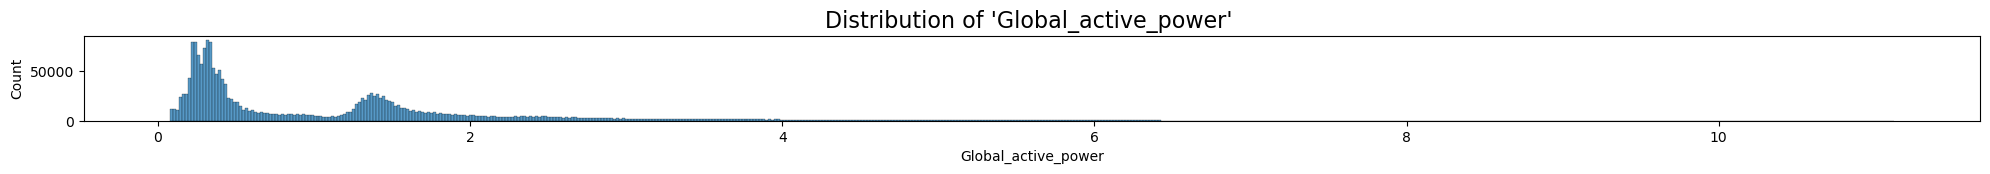

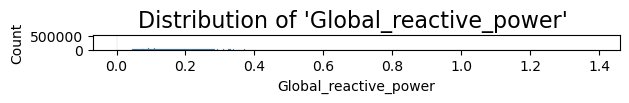

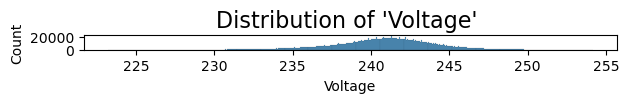

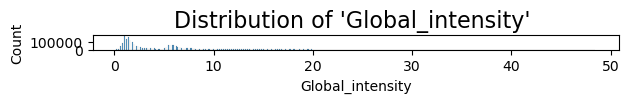

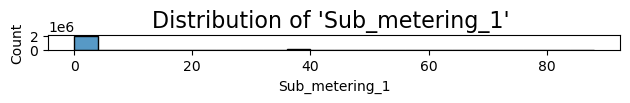

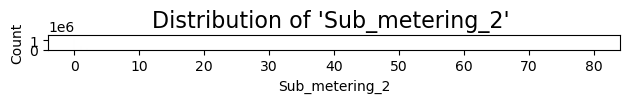

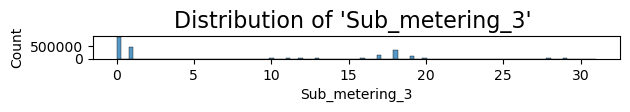

<Figure size 640x480 with 0 Axes>

In [17]:
# Before imputing mean
i = 1
columns = ['Global_active_power',
  'Global_reactive_power',
  'Voltage',
  'Global_intensity',
  'Sub_metering_1',
  'Sub_metering_2',
  'Sub_metering_3']
plt.figure(figsize=(20, 10))
for col in columns:
    plt.subplot(len(columns), 1, i)
    plot_histogram(data=data_1, feature=col)
    i += 1
    plt.tight_layout();

In [18]:
data_2 = data_1.copy()

# Impute missing values
mean_data = np.mean(data_2[['Global_active_power',
                            'Global_reactive_power',
                            'Voltage',
                            'Global_intensity',
                            'Sub_metering_1',
                            'Sub_metering_2',
                            'Sub_metering_3']])
data_2[['Global_active_power',
  'Global_reactive_power',
  'Voltage',
  'Global_intensity',
  'Sub_metering_1',
  'Sub_metering_2',
  'Sub_metering_3']] = data_2[['Global_active_power',
                              'Global_reactive_power',
                              'Voltage',
                              'Global_intensity',
                              'Sub_metering_1',
                              'Sub_metering_2',
                              'Sub_metering_3']].fillna(value=mean_data)

# Verify
data_2.isna().sum()

C:\New folder\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

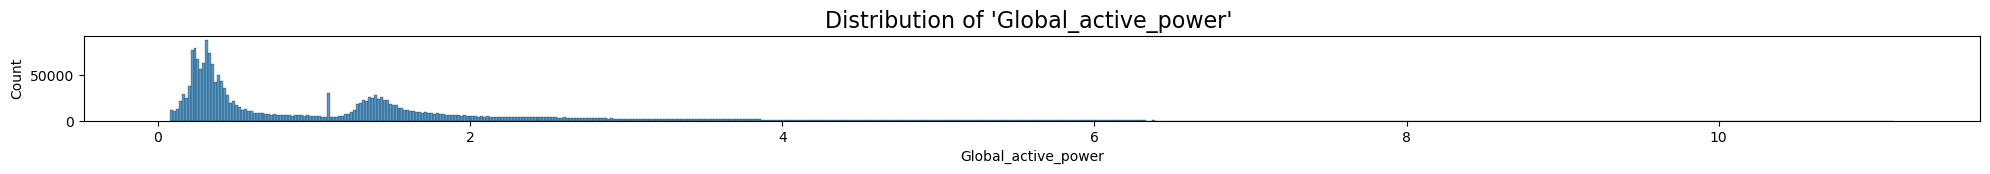

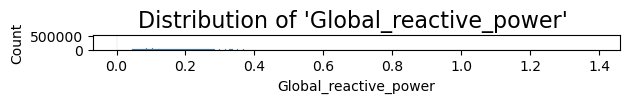

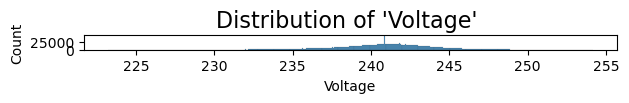

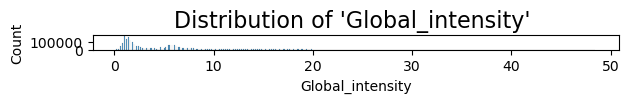

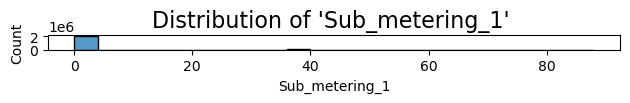

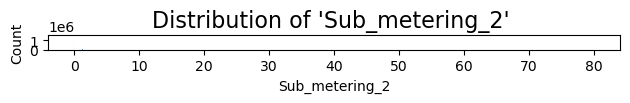

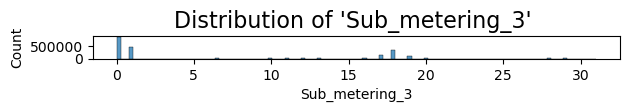

<Figure size 640x480 with 0 Axes>

In [19]:
# After Imputing mean to fill missing values
i = 1
columns = ['Global_active_power',
  'Global_reactive_power',
  'Voltage',
  'Global_intensity',
  'Sub_metering_1',
  'Sub_metering_2',
  'Sub_metering_3']
plt.figure(figsize=(20, 10))
for col in columns:
    plt.subplot(len(columns), 1, i)
    plot_histogram(data=data_2, feature=col)
    i += 1
    plt.tight_layout();

# Descriptive Analysis

In [20]:
# Descriptive analysis
data_2.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


for the distribution of mean and median values in all columns, it can be seen that the distribution is not too far away and the data range is small. While the distribution of min and max values has a value that is quite far with a fairly wide data range, especially in the columns "Global_active_power", "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3".

To minimize data that has outliers in time series cases, a safer way is to fill in the missing values with the mean so that the quality of the time data in each column is maintained.

# Explorative Analysis by resampling

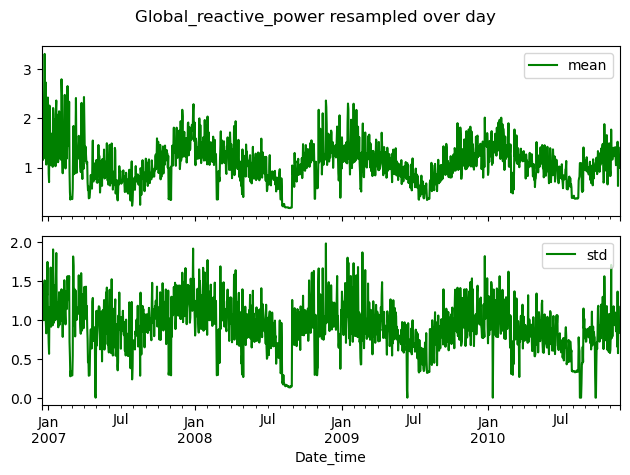

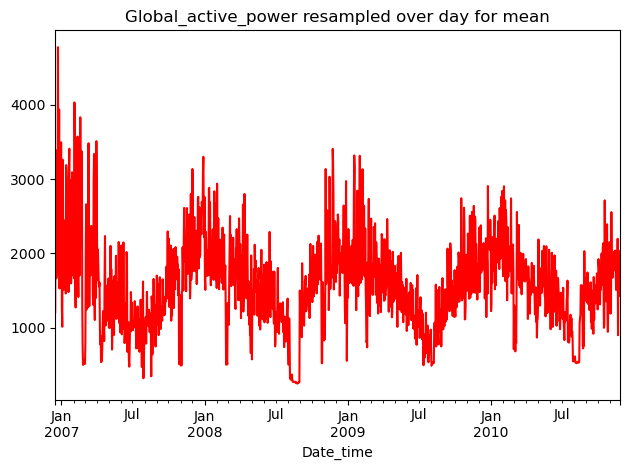

In [21]:
# Resampled over day features("Global_active_power" and 'Global_reactive_power resampled over day') for sum() and for mean()

subplot = data_2.Global_active_power.resample('D').agg(['mean', 'std'])
subplot.plot(subplots = True, title='Global_reactive_power resampled over day', color='green')
plt.tight_layout()
plt.show()

data_2.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for mean', color='red')
plt.tight_layout()
plt.show()

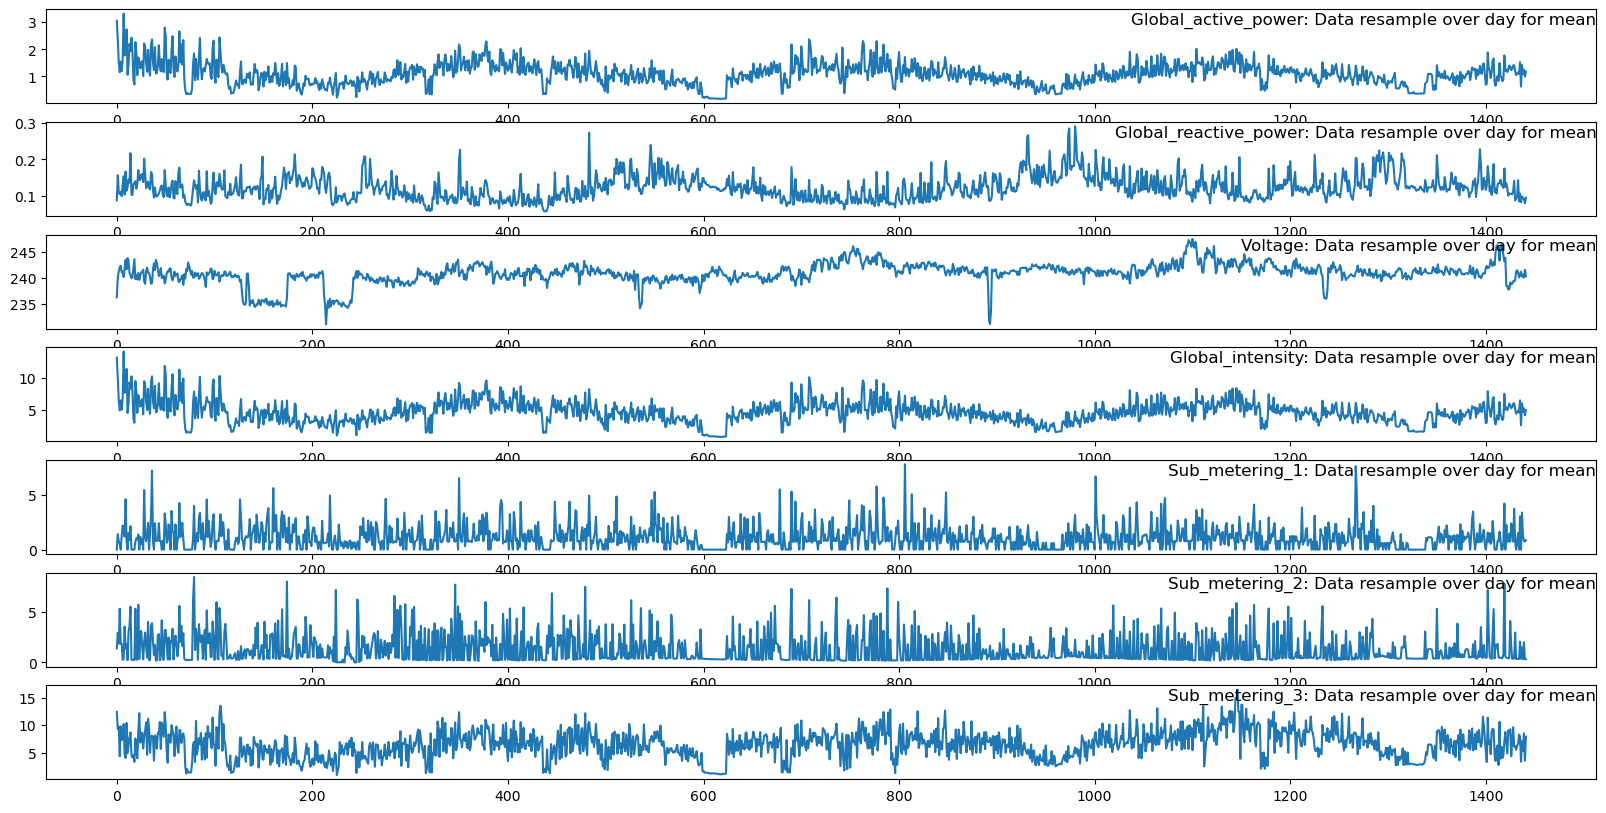

In [22]:
# Plot resampled time series
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data_2.resample('D').mean().values[:, col])
    plt.title(data_2.columns[col] + ': Data resample over day for mean', y=0.75, loc='right')
    i += 1

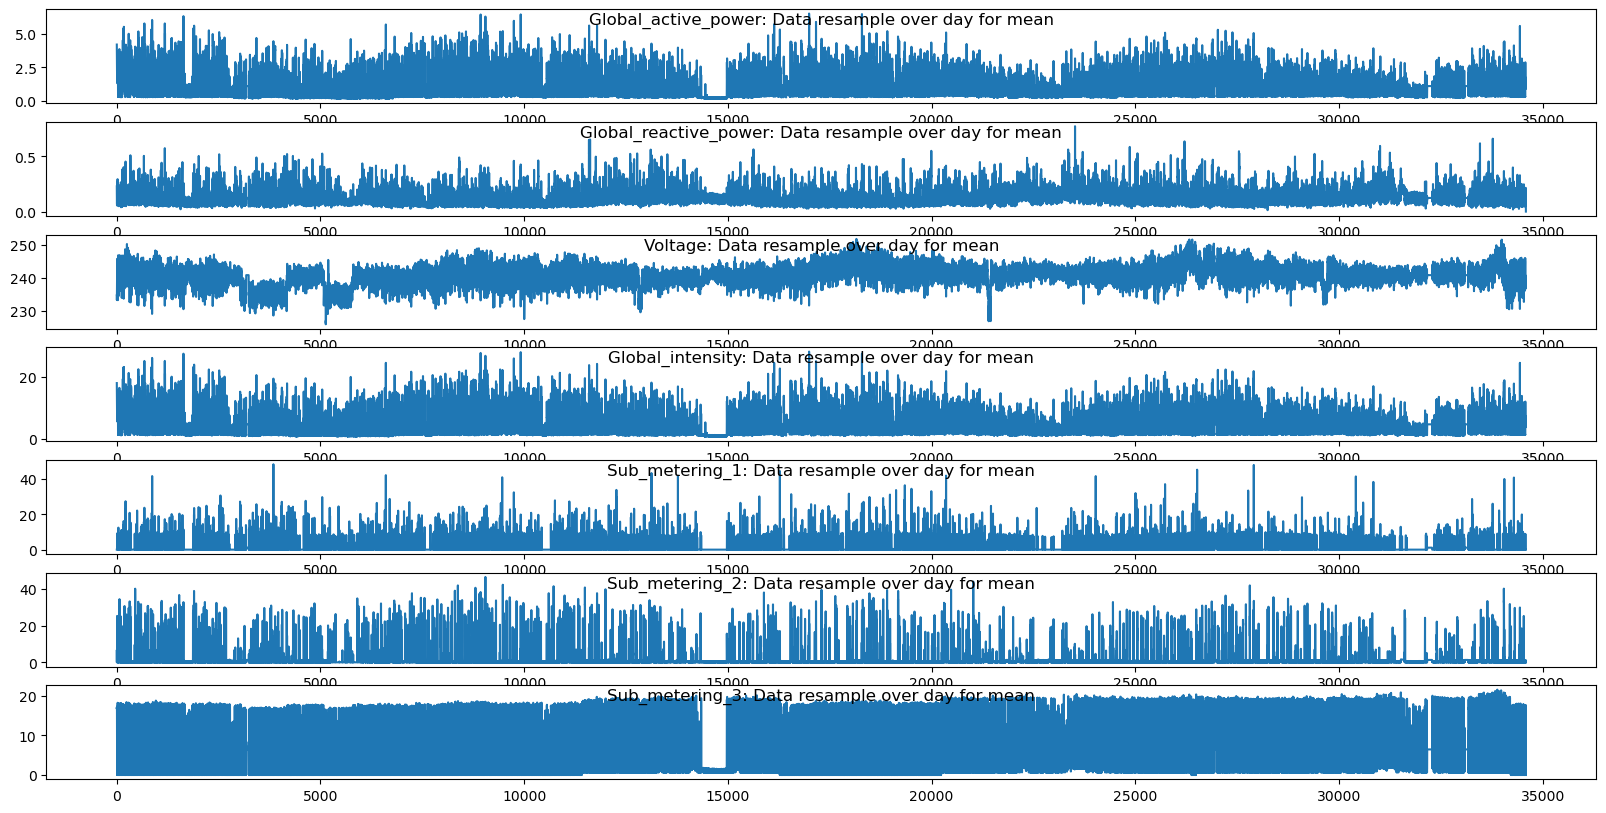

In [23]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data_2.resample('H').mean().values[:, col])
    plt.title(data_2.columns[col] + ': Data resample over day for mean', y=0.75, loc='center')
    i += 1

From above visualized analysis:

The resampling by date/hour is essential,seeing it has a large interaction as expected (changing the periodicity of the system).
If processing data with large time-scale samples (e.g. monthly), it will affect the model's predictivity. From observation, we can see, it is relatively reasonable to resample data by hour

In [24]:
# Correlation view
data_2.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


From above table;

'Global_intensity' and 'Global_active_power' correlated highly.
''Sub_metering_3'' and 'Global_active_power' correlated highly.
'Global_intensity' and 'Sub_metering_3' correlated highly.

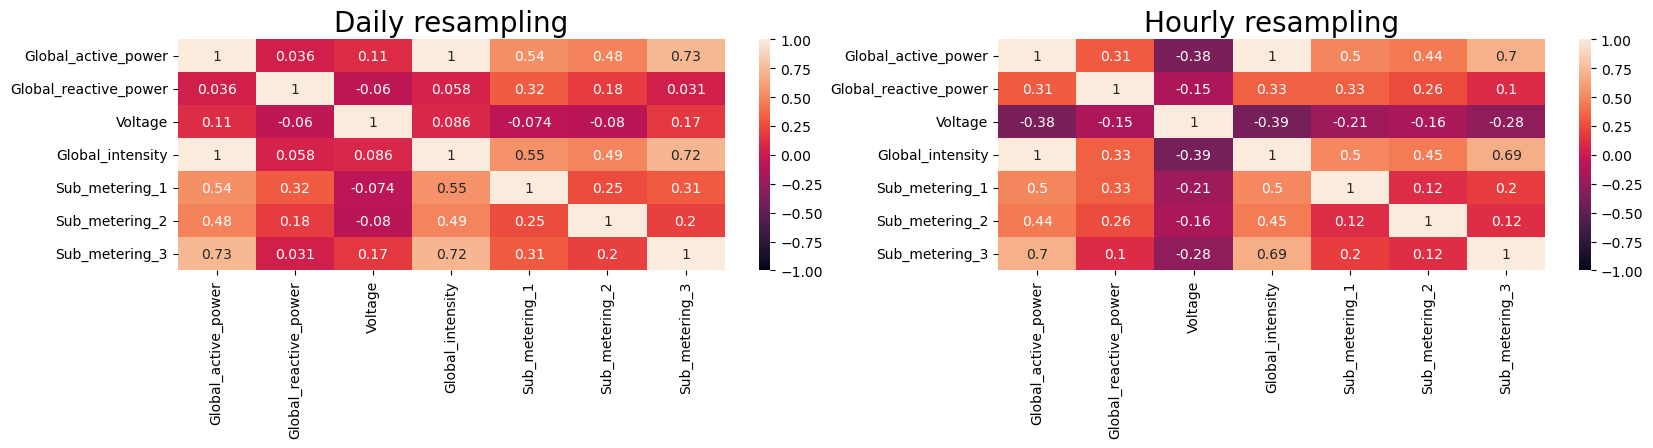

In [25]:
# Plotting with seaborn plot
f= plt.figure(figsize=(30,3))

ax=f.add_subplot(132)
df_daily = data_2.resample('D').mean()
sns.heatmap(df_daily.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=20)

ax=f.add_subplot(133)
df_hourly = data_2.resample('H').mean()
sns.heatmap(df_hourly.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=20)
plt.show()

# Data Preparation and fitting with recurrent nueral network(LSTM Architecture)

In [26]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]

        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names

        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [27]:
data_resampled = data_2.resample('h').mean()
data_resampled.shape

(34589, 7)

# Data Scaling

In [28]:
# Scaling "Global_active_power" column because we want to know for the estimated hourly power consumption for the next day
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_resampled)

data_scaled =pd.DataFrame(scaled)

data_scaled.head()

,0,1,2,3,4,5,6
0,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418
1,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917


In [29]:
data_scaled.shape

(34589, 7)

In [30]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34583,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000
34584,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061
34585,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000
34586,0.161531,0.078993,0.520246,0.158178,0.0,0.022972,0.000000,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000


In [31]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)


reframed=reframed.rename(columns = {'var1(t)': 'target'}, inplace = False)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),target
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


# Splitting Data

In [32]:
# split into train and test sets
values = reframed.values

num_train_time = 365*24
train = values[:num_train_time, :]
test = values[num_train_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


# Data Modelling

In [33]:
# import packages
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import Sequential
import tensorflow as tf


Epoch 1/20
126/126 - 17s - loss: 0.0205 - val_loss: 0.0114 - 17s/epoch - 138ms/step
Epoch 2/20
126/126 - 3s - loss: 0.0121 - val_loss: 0.0106 - 3s/epoch - 27ms/step
Epoch 3/20
126/126 - 4s - loss: 0.0116 - val_loss: 0.0102 - 4s/epoch - 28ms/step
Epoch 4/20
126/126 - 3s - loss: 0.0114 - val_loss: 0.0099 - 3s/epoch - 27ms/step
Epoch 5/20
126/126 - 3s - loss: 0.0111 - val_loss: 0.0096 - 3s/epoch - 27ms/step
Epoch 6/20
126/126 - 3s - loss: 0.0110 - val_loss: 0.0095 - 3s/epoch - 28ms/step
Epoch 7/20
126/126 - 4s - loss: 0.0110 - val_loss: 0.0095 - 4s/epoch - 30ms/step
Epoch 8/20
126/126 - 4s - loss: 0.0110 - val_loss: 0.0094 - 4s/epoch - 28ms/step
Epoch 9/20
126/126 - 3s - loss: 0.0110 - val_loss: 0.0095 - 3s/epoch - 27ms/step
Epoch 10/20
126/126 - 3s - loss: 0.0108 - val_loss: 0.0095 - 3s/epoch - 27ms/step
Epoch 11/20
126/126 - 3s - loss: 0.0109 - val_loss: 0.0096 - 3s/epoch - 28ms/step
Epoch 12/20
126/126 - 3s - loss: 0.0108 - val_loss: 0.0096 - 3s/epoch - 27ms/step
Epoch 13/20
126/126 - 

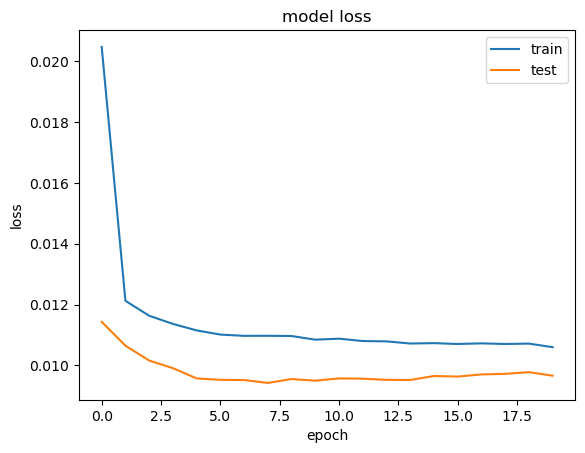

808/808 [==============================] - 6s 6ms/step
Test RMSE: 0.633


In [34]:
# define model architecture
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Final Remarks and conclusion:

In order to improve the model, epochs and batch size has to be adjusted.

The LSTM(long short-term memory) which is now the state-of-the-art for sequencial or time-series problems is USED.

In order to reduce the computation time, and get some results quickly, the first year of data (resampled over hour) to train the model and the rest of data to test the model was taken. 

The above codes work for any time interval (to change the interval, a line in code has to be adjusted).
Together a very simple LSTM neural-network to show that one can obtain reasonable predictions was arrangged. However numbers of rows is too high and as a result the computation is very time-consuming (even for the simple model in the above it took few mins to run). The Best is to write the last part of code using Spark (MLlib) running on GPU.

Moreover, the neural-network architecture that is designed is a toy model. It can be easily improved by dropout and adding CNN layers. The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).